In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi = False

## pip install agc
from agc import * 


# BLOG

context: several files, some with malware; evaluate binary classifiers 

* first one has best ROC, but hits are a bit later
* next has early hits, randomly spread
* next has early hits, biased toward top

10M files, 10k malware, results from 3 algorithms for validation.


In [2]:
n = 10000000
pos = 10000
y_true = np.repeat(0,n-pos)
for i in np.random.choice(n//100, pos, False):
    y_true[i] = 1
y_true = np.concatenate((np.repeat(1,pos),np.repeat(0,n-pos)))

In [3]:
## (algo 1) 10k in top 100k, rest random
K = 100000
p1 = np.concatenate((np.random.uniform(.8,1,pos),np.random.uniform(.8,1,K-pos),np.random.uniform(0,.9,n-K)))

## (algo 2)
p2 = np.concatenate((np.random.uniform(.9,1,150),np.random.uniform(.8,.9,250),np.random.uniform(.7,.8,100),
                    np.random.uniform(.6,.75,pos-500),np.random.uniform(.9,1,350),np.random.uniform(.8,.9,250),
                    np.random.uniform(.7,.8,900),np.random.uniform(.1,.75,n-pos-1500)))


## (algo 3)
p3 = np.concatenate((np.random.uniform(.9,1,250),np.random.uniform(.8,.9,150),np.random.uniform(.7,.8,100),
                    np.random.uniform(.6,.75,pos-500),np.random.uniform(.9,1,250),np.random.uniform(.8,.9,350),
                    np.random.uniform(.7,.8,900),np.random.uniform(.1,.75,n-pos-1500)))



In [4]:
## step 1 - compare AUCs
print(roc_auc_score(y_true, p1))
print(roc_auc_score(y_true, p2))
print(roc_auc_score(y_true, p3))
## first algo seems best here, and all scores are great!

0.9684031833233233
0.889614022982983
0.8898471893593592


In [5]:
## step 2 -  but for data with class imbalance, AP is recommended, let's see
print(average_precision_score(y_true, p1))
print(average_precision_score(y_true, p2))
print(average_precision_score(y_true, p3))
## scores are much lower now, but algo 1 still seems the best choice

0.058162056362981114
0.020590508908246232
0.026813574261237087


In [6]:
## step 3 - limited budget; 
## we will only be able to look at top-1000 files, and this is very optimistic, likely much less
## let's look at precision (or number of hits) in top 1000
T = 1000
x = np.argsort(p1)[-1000:]
print(sum([i<10000 for i in x])/1000)
x = np.argsort(p2)[-1000:]
print(sum([i<10000 for i in x])/1000)
x = np.argsort(p3)[-1000:]
print(sum([i<10000 for i in x])/1000)
## well now, algo 2 or 3 are best, with equal performance; what to do?

0.099
0.4
0.4


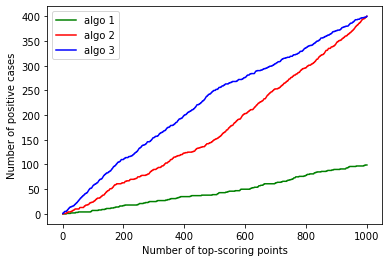

In [7]:
## step 4 - let's look at precision (number of hits) for each values of k<=1000, for the top-k
## we plot those here
top1, tpr1, _  = gain_curve(y_true, p1, truncate=1000)
top2, tpr2, _  = gain_curve(y_true, p2, truncate=1000)
top3, tpr3, _  = gain_curve(y_true, p3, truncate=1000)
plt.plot(top1*n,tpr1*pos,color='green',label='algo 1')
plt.plot(top2*n,tpr2*pos,color='red',label='algo 2')
plt.plot(top3*n,tpr3*pos,color='blue',label='algo 3')
mt = max(top1)
plt.plot([0,mt],[0,mt],color='black')
plt.xlabel('Number of top-scoring points')
plt.ylabel('Number of positive cases')
plt.legend();
## now algo 3 seems better as it gives us earlier hits;
## but is there a measure that would account for this, without the need to look at such plots?
## Indeed, gain curves are similar to ROC curves, but thery can be naturally truncated to compute the area
## in the region of interest; morevoer, we look at this next.

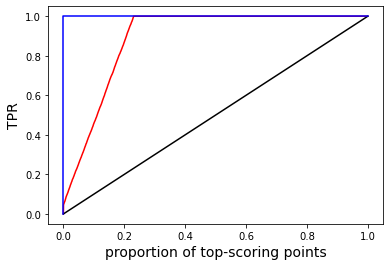

In [8]:
## step 5 - Gain curve: replace FPR in x-axis of ROC with the proportion of points considered
## so when we look at top-k, the x value is k/N and the y-value is the TPR.
## Here is the gain curve shown in red for algo 3; 
## black line is expected results under random point ranking
## blue line is the best possible curve
fpr, tpr, thresholds = roc_curve(y_true, p3)
plt.plot(fpr,tpr,color='red')
plt.plot([0,1],[0,1],color='black')
plt.plot([0,0,1],[0,1,1],color='blue')
plt.xlabel('proportion of top-scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

In [9]:
## We can compute the AGC, which is quite similar to AUC
print(agc_score(y_true, p1, normalized=False))
print(agc_score(y_true, p2, normalized=False))
print(agc_score(y_true, p3, normalized=False))


0.9684189896348174
0.8896692435817909
0.8899022933166584


In [10]:
## Given the nature of the x-axis, we can truncate it so that we only consider the top-k scoring points.
## Moreover, given 
## A(k): actual area under the gain curve truncated at k
## R(k): expected area under the gain curve truncated at k under random classification
## M(k): maximal possible area under the gain curve truncated at k
## then we define the normalized area under the gain curve truncated at k as:
## AGC'(k) = (A(k)-R(k)) / (M(k)-R(k))
## with k=N when there is no truncartion. This represents the proportion of possible gain over random
## that we achieved; note that it can be negative if we do worse than random.

## Let's compute AGC'(1000) for the 3 algorithms
print(agc_score(y_true, p1, normalized=True, truncate=1000))
print(agc_score(y_true, p2, normalized=True, truncate=1000))
print(agc_score(y_true, p3, normalized=True, truncate=1000))
## this corresponds nicely to what we saw in the previous plot.


0.08958858858858859
0.34747547547547547
0.4505885885885886


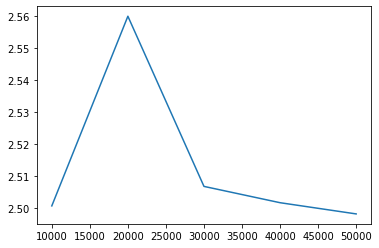

In [11]:
## but how fast is it to compute AGC'(k)?
import time
x = []
X = np.arange(10000,50001,10000)
for t in X:
    start = time.time()
    s = agc_score(y_true, p1, normalized=True, truncate=t)
    x.append(time.time()-start)
plt.plot(X,x);
## truncation value is not relevant, as the bottleneck is to sort the whole vector of scores anyways; 
## size of the dataset is the main factor, see next.

In [12]:
## vary n, 0.1% positives, random classifier, truncate at 1%
x = []
y = []
for i in [16,17,18,19,20,21,22,23,24,25,26,27]: ## 32k to
    n = int(2**i)
    x.append(n)
    pos = n//1000
    y_tr = np.concatenate((np.repeat(1,pos),np.repeat(0,n-pos)))
    ctr = 0
    for z in range(10):
        proba = np.random.random(n)
        start = time.time()
        s = agc_score(y_tr, proba, normalized=True, truncate=n//100)
        ctr += (time.time()-start)    
    y.append(ctr/10)

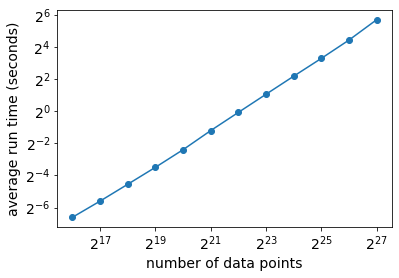

In [13]:
plt.loglog(x[:12],y[:12],'o-',base=2)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('number of data points', fontsize=14)
plt.ylabel('average run time (seconds)', fontsize=14);


In [14]:
2**27

134217728